In [106]:
from copy import deepcopy
from typing import Optional, Union
import numpy as np
import cv2
from matplotlib import pyplot as plt
from operator import itemgetter
import keras
from keras import layers

## Sudoku Solver Class
The below class implements a solver for the Sudoku puzzle family, using the wave function collapse approach.

In [71]:
BoardSuperposition = list[list[Union[set[int], int]]]
Square = tuple[int, int]
# ConstraintBoard's con_board is a 2D list of where con_board[x][y] is a set of possible numbers in the square
# Squares that are filled in instead just have the corresponding int
class ConstraintBoard:
    """
    A ConstraintBoard represents a Sudoku board, where the set at x, y in its con_board represents all the
    possible numbers for the blank square at row x, column y in the corresponding Sudoku.
    If conv_board[x][y] is a singleton set, it represents a filled square.
    """
    def __init__(self, box_size: int=3, coords: Optional[list[tuple[int, int, int]]]=None, matrix: Optional[list[list[int]]]=None) -> None:
        self.box_size = box_size
        self.length = box_size**2
        # Initialise a blank board with all possible numbers for each square
        if coords:
            self.con_board = self.board_from_coords(coords)
        elif matrix:
            self.con_board = self.board_from_matrix(matrix)
        else:
            self.con_board = self.init_blank_board()
            
    def init_blank_board(self) -> BoardSuperposition:
        """
        Returns a blank board
        """
        return [[set(range(1, self.length+1)) for _ in range(self.length)] for _ in range(self.length)]
        
                        
    def board_from_coords(self, coords: list[tuple[int, int, int]]) -> BoardSuperposition:
        """
        Initialise a board from a list of square coordinates and numbers
        """
        new_board = self.init_blank_board()
        for (x, y, num) in coords: 
            new_board = self.fill_square((x, y), num, new_board)
        return new_board

    def board_from_matrix(self, matrix: list[list[int]], blank: int=0) -> BoardSuperposition:
        """
        Intialise a board from a 2D list representing squares in a Sudoku board
        """
        new_board = self.init_blank_board()
        for x in range(len(matrix)):
            for y in range(len(matrix[x])):
                num = matrix[x][y]
                if num != blank:
                    new_board = self.fill_square((x, y), num, new_board)
        return new_board

    def solve(self, board: BoardSuperposition) -> Optional[BoardSuperposition]:
        """
        Recursively fill in squares, backtracking if necessary until a solution is achieved
        """
        square = self.get_next_empty(board)
        # We've solved it!
        if not square:
            return board

        options = board[square[0]][square[1]]
        if type(options) == int:
            raise TypeError("The picked square to fill is already filled")
        # Recursively split to try every possible number for the given square
        for option in options:
            new_board = self.fill_square(square, option, board)
            if self.check_unsolvable(new_board):
                continue
            solution = self.solve(new_board)
            # Only care about the first solution
            if solution:
                return solution
        # The given board is unsolvable
        return None
    
    def get_next_empty(self, board: BoardSuperposition) -> Optional[Square]:
        """
        Find the next empty square with fewest possible numbers, return its coords as a tuple
        """
        best_square = None
        cur_fewest = self.length + 1

        for row in range(self.length):
            for col in range(self.length):
                if type(board[row][col]) != int and len(board[row][col]) < cur_fewest:
                    best_square = (row, col)
                    cur_fewest = len(board[row][col])
        return best_square

    def fill_square(self, square: Square, num: int, board: BoardSuperposition) -> BoardSuperposition:
        """
        Returns a copy of the supplied board with 'square' filled with 'num' and 'num' removed as a possibility from squares
        in the same row, column, and box.
        """
        new_board = deepcopy(board)
        squares = self.get_squares(square)
        for (row, col) in squares:
            if type(board[row][col]) != int:
                new_board[row][col].discard(num)
        new_board[square[0]][square[1]] = num
        return new_board

    def get_squares(self, square: Square) -> set[Square]:
        """
        Gets the coordinates of every other square in the same row, column, and square
        """
        # Which box the square is in, e.g. (0, 0) is the top-leftmost box
        box = (square[0]//self.box_size, square[1]//self.box_size)
        indices = range(self.length)
        same_row = {(num, square[1]) for num in indices}
        same_col = {(square[0], num) for num in indices}
        same_box = {(self.box_size*box[0]+i, self.box_size*box[1]+j) 
                    for i in range(self.box_size) for j in range(self.box_size)}
        squares = same_row | same_col | same_box
        # The square being filled should keep the number as a possibility
        squares.remove(square)
        return squares
    
    def check_unsolvable(self, board: BoardSuperposition) -> bool:
        """
        Returns True if the given board cannot be solved, i.e. has a square with no possible number to fill it.
        Returns False otherwise.
        """
        for row in board:
            for square in row:
                if type(square) != int and len(square) < 1:
                    return True
        return False

Here's a demonstration of it solving a sample Sudoku puzzle:

In [ ]:
# sample = [(0,4,8),(0,6,5),(1,0,2),(1,2,4),(1,5,3),(1,8,7),(2,7,9),(2,8,1),(3,0,6),(3,5,1),(4,1,2),(4,3,6),(4,4,9),
#          (4,5,8),(4,7,3),(5,3,3),(5,8,6),(6,0,7),(6,1,6),(7,0,8),(7,3,9),(7,6,2),(7,8,3),(8,2,3),(8,4,5)]
sample = [
 [0, 2, 8, 0, 0, 0, 9, 7, 0],
 [4, 0, 0, 9, 0, 6, 0, 0, 2],
 [9, 0, 0, 0, 0, 0, 0, 0, 4],
 [0, 5, 0, 0, 8, 0, 0, 2, 0],
 [0, 0, 0, 3, 0, 5, 0, 0, 0],
 [0, 1, 0, 0, 6, 0, 0, 3, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 9],
 [3, 0, 0, 7, 0, 1, 0, 0, 8],
 [0, 7, 2, 0, 0, 0, 1, 5, 0]]
original = ConstraintBoard(matrix=sample)
original.solve(original.con_board)

[[5, 2, 8, 1, 4, 3, 9, 7, 6],
 [4, 3, 1, 9, 7, 6, 5, 8, 2],
 [9, 6, 7, 5, 2, 8, 3, 1, 4],
 [7, 5, 3, 4, 8, 9, 6, 2, 1],
 [2, 4, 6, 3, 1, 5, 8, 9, 7],
 [8, 1, 9, 2, 6, 7, 4, 3, 5],
 [1, 8, 5, 6, 3, 2, 7, 4, 9],
 [3, 9, 4, 7, 5, 1, 2, 6, 8],
 [6, 7, 2, 8, 9, 4, 1, 5, 3]]

## Image Square Extraction Class
The below class provides utility for the loading of an image of a Sudoku and the extraction of each of the squares in the puzzle

In [73]:
# Load image
# Threshold image to binary
# Find contours
# Find square with largest area
# Apply perspective transform
# Get each individual square
# Use OCR to extract digits from non-empty cells
# Solve

class SudokuOCR:
    def image_to_sudoku(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        ret_val, thresholded = cv2.threshold(src=image, thresh=127, maxval=255, type=cv2.THRESH_BINARY)
        

In [74]:
SIDE_LENGTH = 9
image = cv2.imread("example sudoku.webp", cv2.IMREAD_COLOR)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Convert to a binary image, swapping white and black
ret_val, thresholded = cv2.threshold(src=grayscale, thresh=127, maxval=255, type=cv2.THRESH_BINARY_INV)
# Extract every object that is black in the original image
contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Get the squares by extracting the 1st through 81st highest area shapes
squares = sorted(contours, 
                 key=cv2.contourArea, reverse=True)[1:SIDE_LENGTH**2+1]
# Find the leftmost and topmost coords for each square
maxes = [(square, min(square[:,0,0]), max(square[:,0,1])) for square in squares]
# Order the squares in a 2D list, from top to bottom, left to right
top_bottom = [sorted(maxes, key=itemgetter(2))[i:i+SIDE_LENGTH] for i in range(0, SIDE_LENGTH**2, SIDE_LENGTH)]
left_right = [sorted(row, key=itemgetter(1)) for row in top_bottom]
arranged = [[col[0] for col in row] for row in left_right]

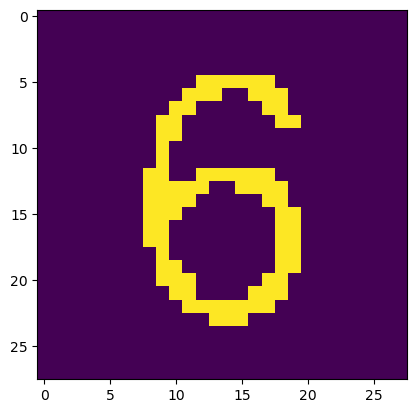

In [132]:
contour = arranged[0][1]
def prepare_square(contour, image, target_size: tuple[int, int]=(28, 28)):
    """
    Extract the center of the square within the given contour, cut off the borders, and resize it
    """
    x, y, w, h = cv2.boundingRect(contour)
    x += int(0.1*w)
    y += int(0.1*h)
    w = int(0.8*w)
    h = int(0.8*h)
    contents = image[y:y+h, x:x+w]
    resized = cv2.resize(contents, target_size, interpolation = cv2.INTER_CUBIC)
    # Re-threshold the image
    _, thresholded = cv2.threshold(
        src=resized, thresh=127, maxval=1, type=cv2.THRESH_BINARY)
    return thresholded

square = prepare_square(contour, thresholded)
plt.imshow(square)

## Train a Convolutional Neural Network

In [117]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Remove the instances of the digit 0, since it isn't used in Sudoku
non_zero_train = y_train != 0
x_train = x_train[non_zero_train]
y_train = y_train[non_zero_train]
non_zero_test = y_test != 0
x_test = x_test[non_zero_test]
y_test = y_test[non_zero_test]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# Threshold to either 0 or 1
x_train = np.where(x_train > 127, 1, 0)
x_test = np.where(x_test > 127, 1, 0)
# Convert labels to one-hot matrices
y_train = keras.utils.to_categorical(y_train-1, 9)
y_test = keras.utils.to_categorical(y_test-1, 9)

# Create the convolutional neural network
digit_OCR = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(9, activation="softmax")
    ]
)

digit_OCR.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
digit_OCR.fit(x_train, y_train, validation_split=0.2)

(54077, 28, 28) (54077,) (9020, 28, 28) (9020,)
1352/1352 [==============================] - 23s 17ms/step - loss: 0.1441 - accuracy: 0.9571 - val_loss: 0.0620 - val_accuracy: 0.9813


In [133]:
print(square)
print(x_train[0])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 

In [137]:
print(digit_OCR(np.reshape(square, (1, 28, 28, 1)))*100000)

tf.Tensor(
[[1.1020595e-03 4.0283861e+00 5.5355934e+01 1.5671304e-04 5.5454273e+04
  2.2448410e+04 5.9693426e-01 1.6989221e+04 5.0481118e+03]], shape=(1, 9), dtype=float32)
